##Start setup

In [1]:
# google drive settings 
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# google drive settings 
%%capture
%cd /content/gdrive/My\ Drive/NLP

In [3]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable
import keras

Using TensorFlow backend.


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
%%capture 
!pip install scikit-plot

## Support utility functions 

In [ ]:
%%capture
! python -m spacy download it

In [ ]:
import spacy
import re
import it_core_news_sm
nlp =it_core_news_sm.load()

In [ ]:
def clean_tweet(text):   
  #remove urls 
  urls_pattern = 'http\S+'
  clean_version = re.sub(urls_pattern, ' ', text)

  #replace hashtag symbol with whitespace
  hashtag_pattern = '#(\w+)'
  clean_version = re.sub(hashtag_pattern, ' ', clean_version)

  #replace - with whitespace
  clean_version = clean_version.replace('-', ' ')

  clean_version = clean_version.replace('_', ' ')

  #replace \ with whitespace
  clean_version = clean_version.replace('\'' , ' ')

  #remove \n 
  clean_version = clean_version.replace('\n', ' ')

  #remove emoji 
  emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
  clean_version = emoji_pattern.sub(' ',clean_version)

  #remove numbers 
  numbers_pattern = '\d+'
  clean_version = re.sub(numbers_pattern, ' ', clean_version)

  #remove punctuation (remove also @)
  punt_pattern = '[^\w\s]'
  clean_version = re.sub(punt_pattern,' ',clean_version)

  # remove multiple whitespace 
  clean_version = re.sub(' +', ' ', clean_version )

  return clean_version.lower()

In [ ]:
# retrieve italian stopwords from file 
stop_word_file = open("tweet_data/italian_stop_words.txt", "r")
stopwords_italian = stop_word_file.read().split('\n')
set_word = set(stopwords_italian) #transform it to set to allow faster evaluation

def lemmatize_text(text, stopword_list = set_word): 
  final_words = [] 
  lemmas = [token.lemma_ for token in nlp(text) 
              if token.pos_ in {'ADJ', 'ADV', 'NOUN', 'NUMERAL', 'NUM', 'PROPN','VERB'}]
  for word in lemmas:  
    if word not in stopword_list: 
      final_words.append(word)
  return (" ".join(final_words))

## Retrieve original dataset and preprocess them 

Dataset source [GitHub](https://github.com/charlesmalafosse/open-dataset-for-sentiment-analysis 
)

To run only the fist time (the result of the preprocess phase is saved into new csv files) 

### First dataset with tweets about footbal players

In [ ]:
sport_sentiment = pd.read_csv('tweet_data/sentiment.csv', encoding='ISO-8859-1')

In [ ]:
sport_sentiment.shape

(165815, 9)

In [ ]:
sport_sentiment['sentiment'].value_counts()

NEUTRAL     135194
POSITIVE     23552
NEGATIVE      6542
MIXED          527
Name: sentiment, dtype: int64

In [ ]:
sport_sentiment.head(2)

,tweet_date_created,tweet_id,tweet_text,language,sentiment,sentiment_score,cleaned_tweet,clean_tweet,clean_text
0,2018-12-10T10:45:40.865000,1072079899224100865,"@juventusfc @G_Higuain Auguri pipita,sempre co...",it,NEUTRAL,"{""Neutral"":0.858726024627685546875,""Negative"":...",juventusfc g higuain auguri pipita sempre con...,juventusfc g higuain auguri pipita sempre con...,juventusfc higuain augurio pipita
1,2018-06-30T18:41:02.817000,1013130303454498817,@realvarriale @massimozampini @KMbappe @G_Higu...,it,NEUTRAL,"{""Neutral"":0.973993778228759765625,""Negative"":...",realvarriale massimozampini kmbappe g higuain...,realvarriale massimozampini kmbappe g higuain...,realvarriale massimozampini kmbappe higuain pa...


In [ ]:
%%time
sport_sentiment['clean_tweet'] = sport_sentiment['tweet_text'].apply(clean_tweet)

CPU times: user 3.54 s, sys: 14.1 ms, total: 3.55 s
Wall time: 3.56 s


In [ ]:
%%time
sport_sentiment['clean_text'] = sport_sentiment['clean_tweet'].apply(lemmatize_text)

CPU times: user 25min 41s, sys: 2.37 s, total: 25min 43s
Wall time: 25min 45s


In [ ]:
import csv
columns = ['tweet_text', 'clean_tweet', 'clean_text', 'sentiment', 'sentiment_score']
sport_sentiment[columns].to_csv('tweet_data/sport_player_new.csv', index=False, quoting=csv.QUOTE_ALL)

### Second dataset about football teams

In [ ]:
sport_teams = pd.read_csv('tweet_data/sport_sentiment_team_1.csv', encoding='ISO-8859-1')

In [ ]:
sport_teams.shape

(259569, 8)

In [ ]:
sport_teams['sentiment'].value_counts()

NEUTRAL     226868
POSITIVE     22883
NEGATIVE      9441
MIXED          377
Name: sentiment, dtype: int64

In [ ]:
sport_teams.head(2)

,tweet_date_created,tweet_id,tweet_text,language,sentiment,sentiment_score
0,2018-12-10T10:45:40.865000,1072079899224100865,"@juventusfc @G_Higuain Auguri pipita,sempre co...",it,NEUTRAL,"{""Neutral"":0.858726024627685546875,""Negative"":..."
1,2018-12-26T19:40:44.308000,1078012758069858308,@OfficialASRoma @D_10Perotti @Hyundai_Italia S...,it,NEUTRAL,"{""Neutral"":0.9844334125518798828125,""Negative""..."


In [ ]:
%%time
sport_teams['clean_tweet'] = sport_teams['tweet_text'].apply(clean_tweet)

CPU times: user 5.34 s, sys: 66.9 ms, total: 5.41 s
Wall time: 5.41 s


In [ ]:
%%time
sport_teams['clean_text'] = sport_teams['clean_tweet'].apply(lemmatize_text)

CPU times: user 40min 51s, sys: 3.72 s, total: 40min 55s
Wall time: 40min 58s


In [ ]:
import csv
columns = ['tweet_text', 'clean_tweet', 'clean_text', 'sentiment', 'sentiment_score']
sport_teams[columns].to_csv('tweet_data/sport_teams_new.csv', index=False, quoting=csv.QUOTE_ALL)

### Create global sport dataset

In [ ]:
player_sentiment = pd.read_csv('tweet_data/sport_player_new.csv', encoding='ISO-8859-1')
team_sentiment = pd.read_csv('tweet_data/sport_teams_new.csv', encoding='ISO-8859-1')

In [ ]:
# drop nan 
player_sentiment = player_sentiment[player_sentiment.clean_text.isna() == False ]
team_sentiment = team_sentiment[team_sentiment.clean_text.isna() == False ]

#drop "mixed" sentiment 
player_red = player_sentiment[player_sentiment.sentiment!='MIXED']
team_red = team_sentiment[team_sentiment.sentiment!='MIXED']

In [ ]:
player_red.shape

(165281, 5)

In [ ]:
player_red_counts = player_red['sentiment'].value_counts()
player_red_counts

NEUTRAL     135187
POSITIVE     23552
NEGATIVE      6542
Name: sentiment, dtype: int64

In [ ]:
print("neutral {}".format(player_red_counts[0]/player_red.shape[0] *100))
print("positive {}".format(player_red_counts[1]/player_red.shape[0] *100))
print("negative {}".format(player_red_counts[2]/player_red.shape[0] *100))

neutral 81.79222052141505
positive 14.249671771104966
negative 3.958107707479989


In [ ]:
team_red.shape

(258354, 5)

In [ ]:
team_red_counts = team_red['sentiment'].value_counts()
team_red_counts

NEUTRAL     226102
POSITIVE     22813
NEGATIVE      9439
Name: sentiment, dtype: int64

In [ ]:
print("neutral {}".format(team_red_counts[0]/team_red.shape[0] *100))
print("positive {}".format(team_red_counts[1]/team_red.shape[0] *100))
print("negative {}".format(team_red_counts[2]/team_red.shape[0] *100))

neutral 87.51635353042724
positive 8.830132299093492
negative 3.653514170479265


In [ ]:
# create global dataset 
sport_sentiment_full = pd.concat([player_red, team_red], ignore_index=True)
sport_sentiment_full.shape

(423635, 5)

In [ ]:
sentiment_counts = sport_sentiment_full['sentiment'].value_counts()
sentiment_counts

NEUTRAL     361289
POSITIVE     46365
NEGATIVE     15981
Name: sentiment, dtype: int64

In [ ]:
print("neutral {}".format(sentiment_counts[0]/sport_sentiment_full.shape[0] *100))
print("positive {}".format(sentiment_counts[1]/sport_sentiment_full.shape[0] *100))
print("negative {}".format(sentiment_counts[2]/sport_sentiment_full.shape[0] *100))


neutral 85.28308567516848
positive 10.944563126276158
negative 3.7723511985553597


In [ ]:
# # create global balanced dataset
# sport_sentiment = sport_sentiment_full.groupby('sentiment').apply(lambda x: x.sample(n=15981)).reset_index(drop = True)
# sport_sentiment.shape

In [ ]:
# sport_sentiment['sentiment'].value_counts()

In [ ]:
sport_sentiment_full.isna().any()

tweet_text         False
clean_tweet        False
clean_text         False
sentiment          False
sentiment_score    False
dtype: bool

# Models

In [7]:
# if already run, load train and test files
train = pd.read_csv("tweet_data/train.csv", lineterminator='\n')
test = pd.read_csv("tweet_data/test.csv", lineterminator='\n') 
train_under = pd.read_csv("tweet_data/train_under.csv", lineterminator='\n')

In [ ]:
# otherwise divide train and test 
from sklearn.model_selection import train_test_split
train, test = train_test_split(sport_sentiment_full, test_size=0.33, random_state=42)
print("Train", train.shape)
print("Test", test.shape)

Train (283835, 5)
Test (139800, 5)


In [ ]:
# To run only the first time to save the train and test dataset
# train.to_csv('tweet_data/train.csv', index = False)
# test.to_csv('tweet_data/test.csv', index = False)

In [ ]:
train['sentiment'].value_counts()

NEUTRAL     242084
POSITIVE     30994
NEGATIVE     10757
Name: sentiment, dtype: int64

In [ ]:
# under-sampling --> the category with less instances is the negative one with 10757 rows 
train_under = train.groupby('sentiment').apply(lambda x: x.sample(n=10757)).reset_index(drop = True)
# train_under.to_csv('tweet_data/train_under.csv')

In [ ]:
train_under.shape

(32271, 5)

In [ ]:
train_under['sentiment'].value_counts()

POSITIVE    10757
NEUTRAL     10757
NEGATIVE    10757
Name: sentiment, dtype: int64

## Logistic regression

In [5]:
# load the models (if already trained to avoid re-run all)
from joblib import load
logistic_under = load('tweet_data/models/logistic_under.joblib') 
logistic_over = load('tweet_data/models/logistic_over.joblib') 
logistic_original = load('tweet_data/models/logistic_original.joblib')

### Original dataset

In [11]:
# transfrom label into numbers
from sklearn.preprocessing import LabelEncoder
labels2numbers = LabelEncoder()
y_original = labels2numbers.fit_transform(train['sentiment'])
print(labels2numbers.classes_)

['NEGATIVE' 'NEUTRAL' 'POSITIVE']


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,4), 
                             min_df=0.001, 
                             max_df=0.75)

X_original = vectorizer.fit_transform(train['clean_text'])
print(X_original.shape)

(283835, 1578)


In [ ]:
# fitting the model 
from sklearn.linear_model import LogisticRegression
logistic_original = LogisticRegression(n_jobs=-1)
%time logistic_original.fit(X_original, y_original)
print(logistic_original)

CPU times: user 39.7 ms, sys: 126 ms, total: 166 ms
Wall time: 12.8 s
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [12]:
new_X = vectorizer.transform(test['clean_text']) # transform text into word counts 
new_y = labels2numbers.transform(test['sentiment']) # transfrom label into numbers 
new_predictions = logistic_original.predict(new_X) # prediction using the logistic classifier 

In [ ]:
new_X.shape

(139800, 1578)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(new_y, new_predictions))

              precision    recall  f1-score   support

           0       0.63      0.18      0.28      5224
           1       0.89      0.98      0.93    119205
           2       0.70      0.34      0.45     15371

    accuracy                           0.88    139800
   macro avg       0.74      0.50      0.56    139800
weighted avg       0.86      0.88      0.85    139800



In [31]:
# baseline, assign all tweets to the most frequent category (neutral)
baseline_predictions =  [labels2numbers.transform(['NEUTRAL'])] * len(new_y)
print(classification_report(new_y, baseline_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5224
           1       0.85      1.00      0.92    119205
           2       0.00      0.00      0.00     15371

    accuracy                           0.85    139800
   macro avg       0.28      0.33      0.31    139800
weighted avg       0.73      0.85      0.78    139800



In [43]:
# ROC curve 
from sklearn import metrics
fpr_original, tpr_original, thresholds_original = metrics.roc_curve(new_y, new_predictions, pos_label=0)
auc_original = np.trapz(tpr_original,fpr_original)
print('AUC:', auc_original)

AUC: 0.3951397546554473


In [44]:
# ROC curve 
from sklearn import metrics
fpr_baseline, tpr_baseline, thresholds_baseline = metrics.roc_curve(new_y, baseline_predictions, pos_label=0)
auc_baseline = np.trapz(tpr_baseline,fpr_baseline)
print('AUC:', auc_baseline)

AUC: 0.5


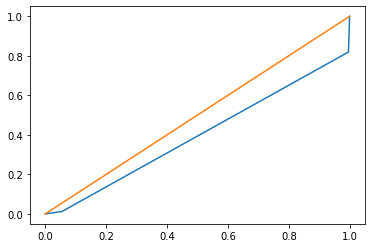

In [37]:
import matplotlib.pyplot as plt
# Print ROC curve
plt.plot(fpr_original,tpr_original)
plt.plot(fpr_baseline, tpr_baseline)
plt.show() 

In [ ]:
# save the model 
from joblib import dump
dump(logistic_original, 'tweet_data/models/logistic_original.joblib') 

['tweet_data/models/logistic_original.joblib']

### Under-sampling dataset

In [45]:
#transfrom label into numbers
from sklearn.preprocessing import LabelEncoder
labels2numbers = LabelEncoder()
y_under = labels2numbers.fit_transform(train_under['sentiment'])
print(labels2numbers.classes_)

['NEGATIVE' 'NEUTRAL' 'POSITIVE']


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,4), 
                             min_df=0.001, 
                             max_df=0.75)

X_under = vectorizer.fit_transform(train_under['clean_text'])
print(X_under.shape)

(32271, 1610)


In [ ]:
#fitting the model 
from sklearn.linear_model import LogisticRegression
logistic_under = LogisticRegression(n_jobs=-1, class_weight='balanced')
%time logistic_under.fit(X_under, y_under)
print(logistic_under)

CPU times: user 19.3 ms, sys: 58.8 ms, total: 78.1 ms
Wall time: 2.56 s
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [47]:
new_X = vectorizer.transform(test['clean_text']) # transform text into word counts 
new_y = labels2numbers.transform(test['sentiment']) # transfrom label into numbers 
new_predictions = logistic_under.predict(new_X) # prediction using the logistic classifier 

In [ ]:
new_X.shape

(139800, 1610)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(new_y, new_predictions))

              precision    recall  f1-score   support

           0       0.18      0.76      0.29      5224
           1       0.95      0.70      0.81    119205
           2       0.37      0.70      0.48     15371

    accuracy                           0.70    139800
   macro avg       0.50      0.72      0.53    139800
weighted avg       0.86      0.70      0.75    139800



In [49]:
# ROC curve 
from sklearn import metrics
fpr_under, tpr_under, thresholds_under = metrics.roc_curve(new_y, new_predictions, pos_label=0)
auc_under = np.trapz(tpr_under,fpr_under)
print('AUC:', auc_under)

AUC: 0.19211367574307


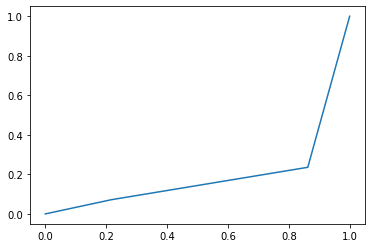

In [50]:
import matplotlib.pyplot as plt
# Print ROC curve
plt.plot(fpr_under,tpr_under)

In [ ]:
# save the model 
from joblib import dump
dump(logistic_under, 'tweet_data/models/logistic_under.joblib') 

['tweet_data/models/logistic_under.joblib']

### Over-sampling dataset

In [ ]:
%%capture
!pip install imbalanced-learn

In [ ]:
#transfrom label into numbers
from sklearn.preprocessing import LabelEncoder
labels2numbers = LabelEncoder()
y = labels2numbers.fit_transform(train['sentiment'])
print(labels2numbers.classes_)

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,4), 
                             min_df=0.001, 
                             max_df=0.75)

X = vectorizer.fit_transform(train['clean_text'])
print(X.shape)

['NEGATIVE' 'NEUTRAL' 'POSITIVE']
(283835, 1578)


In [ ]:
# over-sampling with SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
%time X_over, y_over = oversample.fit_resample(X, y)

CPU times: user 6min 11s, sys: 7.09 s, total: 6min 18s
Wall time: 6min 5s


In [ ]:
X_over.shape

(726252, 1578)

In [ ]:
# save the sparse matrix X_over
from scipy import sparse
sparse.save_npz("X_over.npz", X_over)
np.save('y_over.npy', y_over)

In [ ]:
#fitting the model 
from sklearn.linear_model import LogisticRegression

logistic_over = LogisticRegression(n_jobs=-1, class_weight='balanced')
%time logistic_over.fit(X_over, y_over)
print(logistic_over)

CPU times: user 58.2 ms, sys: 206 ms, total: 264 ms
Wall time: 32.6 s
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
new_X = vectorizer.transform(test['clean_text']) # transform text into word counts
new_y = labels2numbers.transform(test['sentiment']) # transform labels into numbers
new_predictions = logistic_over.predict(new_X) # prediction using the logistic classifier 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(new_y, new_predictions))

              precision    recall  f1-score   support

           0       0.13      0.64      0.22      5224
           1       0.94      0.68      0.78    119205
           2       0.36      0.67      0.47     15371

    accuracy                           0.67    139800
   macro avg       0.48      0.66      0.49    139800
weighted avg       0.84      0.67      0.73    139800



In [ ]:
# save the model 
from joblib import dump
dump(logistic_over, 'tweet_data/models/logistic_over.joblib') 

['tweet_data/models/logistic_over.joblib']

## Deep Learning

We consider only two sentiment: negative and non-negative (that includes positive and neutral tweets)

In [ ]:
train = pd.read_csv("tweet_data/train.csv", lineterminator='\n')
test = pd.read_csv("tweet_data/test.csv", lineterminator='\n')
train_under  = pd.read_csv("tweet_data/train_under.csv", lineterminator='\n')

In [ ]:
# the new train and test files are obtained from the original (unbalanced) version of the sport dataset
train_dual = train[train['sentiment'] != 'NEUTRAL']
test_dual = test[test['sentiment'] != 'NEUTRAL']

In [ ]:
sentiment_label = train_dual.sentiment.factorize()
sentiment_label

(array([0, 1, 0, ..., 0, 0, 1]),
 Index(['POSITIVE', 'NEGATIVE'], dtype='object'))

### LSTM - Binary 

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tweet = train_dual.clean_text # retrive the text data 

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tweet)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet)

padded_sequence = pad_sequences(encoded_docs, maxlen=200) #padding 

In [ ]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
# model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           939168    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 955,819
Trainable params: 955,819
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(padded_sequence,sentiment_label[0],
                  validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
1044/1044 [==============================] - 265s 254ms/step - loss: 0.3302 - accuracy: 0.8569 - val_loss: 0.2440 - val_accuracy: 0.8999
Epoch 2/5
1044/1044 [==============================] - 268s 257ms/step - loss: 0.2103 - accuracy: 0.9178 - val_loss: 0.2358 - val_accuracy: 0.9062
Epoch 3/5
1044/1044 [==============================] - 266s 255ms/step - loss: 0.1834 - accuracy: 0.9302 - val_loss: 0.2365 - val_accuracy: 0.9080
Epoch 4/5
1044/1044 [==============================] - 264s 253ms/step - loss: 0.1626 - accuracy: 0.9380 - val_loss: 0.2466 - val_accuracy: 0.9049
Epoch 5/5
1044/1044 [==============================] - 269s 258ms/step - loss: 0.1485 - accuracy: 0.9449 - val_loss: 0.2560 - val_accuracy: 0.9055


In [ ]:
model.save('lstm.h5')

In [ ]:
# load the lstm model if already trained 
import tensorflow as tf 
model = tf.keras.models.load_model('lstm.h5')
# from keras.models import load_model
# model = load_model('lstm.h5') 

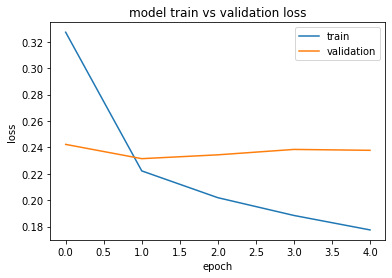

In [ ]:
# plot train and validation loss
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
tw = tokenizer.texts_to_sequences(test_dual.clean_text)
tw = pad_sequences(tw,maxlen=200)
prediction = model.predict(tw)

In [ ]:
# 0 is POSITIVE, 1 is NEGATIVE
# we consider a score < 0.5 as POSITIVE and a score > 0.5 as NEGATIVE
sentiment = []
for pred in prediction: 
  if pred < 0.5: 
    sentiment.append('POSITIVE')
  else: 
    sentiment.append('NEGATIVE')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dual['sentiment'], sentiment))

              precision    recall  f1-score   support

    NEGATIVE       0.82      0.80      0.81      5224
    POSITIVE       0.93      0.94      0.94     15371

    accuracy                           0.90     20595
   macro avg       0.88      0.87      0.87     20595
weighted avg       0.90      0.90      0.90     20595



In [ ]:
print(sentiment[0], test_dual['tweet_text'][15])

NEGATIVE Tanti auguri @G_Higuain sarÃ  ma cmq a me manchi...E mi dispiace vederti li ?auguri #pipita


### LSTM - Categorical

In [ ]:
train = pd.read_csv("tweet_data/train.csv", lineterminator='\n')
test = pd.read_csv("tweet_data/test.csv", lineterminator='\n')
train_under = pd.read_csv("tweet_data/train_under.csv", lineterminator='\n')

#### Under-sampling dataset

In [ ]:
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import keras

train_texts = train_under['clean_text']
test_texts = test['clean_text']

# tokenizer 
t = Tokenizer()
t.fit_on_texts(train_texts)
X_train = t.texts_to_sequences(train_texts)

# transform labels into numbers
labels2numbers = LabelEncoder()
y_train_org = labels2numbers.fit_transform(train_under['sentiment'])


X_test = t.texts_to_sequences(test_texts)
y_test_org = labels2numbers.transform(test['sentiment'])

num_classes = max(y_train_org) + 1 # get number of classes for transformation
vocab_size = len(t.word_index) + 1 # vocabulary size (plus reserved index 0)

y_train = keras.utils.to_categorical(y_train_org, num_classes)
y_test = keras.utils.to_categorical(y_test_org, num_classes)

In [ ]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, CuDNNLSTM, Embedding, Flatten
from keras.layers.core import Lambda, Dropout, Dense, Activation
from keras.layers.convolutional import Conv1D
from keras import backend as K

hidden_dims = 96
lstm_dims = 48

model = Sequential()
model.add(Embedding(output_dim=64, 
                    input_dim=vocab_size,
                    input_length=None))
model.add(LSTM(lstm_dims))
model.add(Dense(hidden_dims))
model.add(Dropout(rate=0.2))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          1844928   
_________________________________________________________________
lstm_1 (LSTM)                (None, 48)                21696     
_________________________________________________________________
dense_1 (Dense)              (None, 96)                4704      
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 291       
_________________________________________________________________
activation_2 (Activation)    (None, 3)                

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# padding 
k = sorted([len(xx) for xx in X_train])
f = k[int(len(k)/100*90)]

maxlen = f
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
batch_size = 32
epochs = 5

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

loss, accuracy = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Train on 25816 samples, validate on 6455 samples
Epoch 1/5
25816/25816 [==============================] - 27s 1ms/step - loss: 0.7317 - accuracy: 0.6850 - val_loss: 1.0292 - val_accuracy: 0.5701
Epoch 2/5
25816/25816 [==============================] - 27s 1ms/step - loss: 0.4685 - accuracy: 0.8214 - val_loss: 0.9965 - val_accuracy: 0.6183
Epoch 3/5
25816/25816 [==============================] - 27s 1ms/step - loss: 0.3383 - accuracy: 0.8748 - val_loss: 1.2906 - val_accuracy: 0.5875
Epoch 4/5
25816/25816 [==============================] - 27s 1ms/step - loss: 0.2568 - accuracy: 0.9093 - val_loss: 1.2512 - val_accuracy: 0.6229
Epoch 5/5
139800/139800 [==============================] - 12s 87us/step
Test loss: 1.1742022013425486
Test accuracy: 0.6444063186645508


In [ ]:
model.save('lstm_category_under.h5')

In [ ]:
prediction = model.predict(X_test)
sentiment = []
for pred in prediction: 
  sentiment.append(labels2numbers.inverse_transform([pred.argmax()])[0])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test['sentiment'], sentiment))

              precision    recall  f1-score   support

    NEGATIVE       0.43      0.33      0.37      5224
     NEUTRAL       0.91      0.94      0.92    119205
    POSITIVE       0.58      0.45      0.50     15371

    accuracy                           0.87    139800
   macro avg       0.64      0.57      0.60    139800
weighted avg       0.85      0.87      0.86    139800



#### Over-sampling dataset

In [ ]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import keras

train_texts = train['clean_text']
test_texts = test['clean_text']

# tokenizer 
t = Tokenizer()
t.fit_on_texts(train_texts)
X_train = t.texts_to_sequences(train_texts)

# transform labels into numbers
labels2numbers = LabelEncoder()
y_train_org = labels2numbers.fit_transform(train['sentiment'])

X_test = t.texts_to_sequences(test_texts)
y_test_org = labels2numbers.transform(test['sentiment'])

num_classes = max(y_train_org) + 1 # get number of classes for transformation
vocab_size = len(t.word_index) + 1 # vocabulary size (plus reserved index 0)

y_train = keras.utils.to_categorical(y_train_org, num_classes)
y_test = keras.utils.to_categorical(y_test_org, num_classes)

In [ ]:
# padding 
k = sorted([len(xx) for xx in X_train])
f = k[int(len(k)/100*90)]

from keras.preprocessing.sequence import pad_sequences
maxlen = f
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# over-sampling with SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
%time X_over, y_over = oversample.fit_resample(X_train, y_train)

CPU times: user 16.8 s, sys: 402 µs, total: 16.8 s
Wall time: 16.8 s


In [ ]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, CuDNNLSTM, Embedding, Flatten
from keras.layers.core import Lambda, Dropout, Dense, Activation
from keras.layers.convolutional import Conv1D
from keras import backend as K

hidden_dims = 96
lstm_dims = 48

model = Sequential()
model.add(Embedding(output_dim=64, 
                    input_dim=vocab_size,
                    input_length=None))
model.add(LSTM(lstm_dims))
model.add(Dense(hidden_dims))
model.add(Dropout(rate=0.2))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          6420480   
_________________________________________________________________
lstm_3 (LSTM)                (None, 48)                21696     
_________________________________________________________________
dense_5 (Dense)              (None, 96)                4704      
_________________________________________________________________
dropout_3 (Dropout)          (None, 96)                0         
_________________________________________________________________
activation_5 (Activation)    (None, 96)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 291       
_________________________________________________________________
activation_6 (Activation)    (None, 3)                

In [ ]:
batch_size = 32
epochs = 5

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

loss, accuracy = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Train on 227068 samples, validate on 56767 samples
Epoch 1/5
227068/227068 [==============================] - 607s 3ms/step - loss: 0.3605 - accuracy: 0.8748 - val_loss: 0.3339 - val_accuracy: 0.8801
Epoch 2/5
227068/227068 [==============================] - 602s 3ms/step - loss: 0.2933 - accuracy: 0.8904 - val_loss: 0.3302 - val_accuracy: 0.8805
Epoch 3/5
227068/227068 [==============================] - 597s 3ms/step - loss: 0.2470 - accuracy: 0.9067 - val_loss: 0.3621 - val_accuracy: 0.8736
Epoch 4/5
227068/227068 [==============================] - 596s 3ms/step - loss: 0.2057 - accuracy: 0.9232 - val_loss: 0.4206 - val_accuracy: 0.8649
Epoch 5/5
139800/139800 [==============================] - 11s 78us/step
Test loss: 0.468470223671377
Test accuracy: 0.8626537919044495


In [ ]:
model.save('lstm_category_over.h5')

In [ ]:
prediction = model.predict(X_test)
sentiment = []
for pred in prediction: 
  sentiment.append(labels2numbers.inverse_transform([pred.argmax()])[0])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test['sentiment'], sentiment))

              precision    recall  f1-score   support

    NEGATIVE       0.43      0.34      0.38      5224
     NEUTRAL       0.91      0.93      0.92    119205
    POSITIVE       0.56      0.49      0.52     15371

    accuracy                           0.86    139800
   macro avg       0.63      0.59      0.61    139800
weighted avg       0.85      0.86      0.86    139800



#### Original (unbalanced) dataset

In [ ]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import keras

train_texts = train['clean_text']
test_texts = test['clean_text']

# tokenizer 
t = Tokenizer()
t.fit_on_texts(train_texts)
X_train = t.texts_to_sequences(train_texts)

# transform labels into numbers
labels2numbers = LabelEncoder()
y_train_org = labels2numbers.fit_transform(train['sentiment'])


X_test = t.texts_to_sequences(test_texts)
y_test_org = labels2numbers.transform(test['sentiment'])

num_classes = max(y_train_org) + 1 # get number of classes for transformation
vocab_size = len(t.word_index) + 1 # vocabulary size (plus reserved index 0)

y_train = keras.utils.to_categorical(y_train_org, num_classes)
y_test = keras.utils.to_categorical(y_test_org, num_classes)

In [ ]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, CuDNNLSTM, Embedding, Flatten
from keras.layers.core import Lambda, Dropout, Dense, Activation
from keras.layers.convolutional import Conv1D
from keras import backend as K

hidden_dims = 96
lstm_dims = 48

model = Sequential()
model.add(Embedding(output_dim=64, 
                    input_dim=vocab_size,
                    input_length=None))
model.add(LSTM(lstm_dims))
model.add(Dense(hidden_dims))
model.add(Dropout(rate=0.2))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          6420480   
_________________________________________________________________
lstm_2 (LSTM)                (None, 48)                21696     
_________________________________________________________________
dense_3 (Dense)              (None, 96)                4704      
_________________________________________________________________
dropout_2 (Dropout)          (None, 96)                0         
_________________________________________________________________
activation_3 (Activation)    (None, 96)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 291       
_________________________________________________________________
activation_4 (Activation)    (None, 3)                

In [ ]:
# padding 
k = sorted([len(xx) for xx in X_train])
f = k[int(len(k)/100*90)]

from keras.preprocessing.sequence import pad_sequences
maxlen = f
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
batch_size = 32
epochs = 5

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

loss, accuracy = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Train on 227068 samples, validate on 56767 samples
Epoch 1/5
227068/227068 [==============================] - 611s 3ms/step - loss: 0.3608 - accuracy: 0.8753 - val_loss: 0.3314 - val_accuracy: 0.8797
Epoch 2/5
227068/227068 [==============================] - 605s 3ms/step - loss: 0.2927 - accuracy: 0.8908 - val_loss: 0.3352 - val_accuracy: 0.8797
Epoch 3/5
227068/227068 [==============================] - 595s 3ms/step - loss: 0.2452 - accuracy: 0.9077 - val_loss: 0.3723 - val_accuracy: 0.8726
Epoch 4/5
227068/227068 [==============================] - 601s 3ms/step - loss: 0.2047 - accuracy: 0.9234 - val_loss: 0.4120 - val_accuracy: 0.8570
Epoch 5/5
139800/139800 [==============================] - 11s 81us/step
Test loss: 0.4464702679867055
Test accuracy: 0.8644635081291199


In [ ]:
model.save('lstm_category.h5')

In [ ]:
prediction = model.predict(X_test)
sentiment = []
for pred in prediction: 
  sentiment.append(labels2numbers.inverse_transform([pred.argmax()])[0])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test['sentiment'], sentiment))

              precision    recall  f1-score   support

    NEGATIVE       0.48      0.31      0.38      5224
     NEUTRAL       0.91      0.93      0.92    119205
    POSITIVE       0.55      0.51      0.53     15371

    accuracy                           0.86    139800
   macro avg       0.65      0.58      0.61    139800
weighted avg       0.86      0.86      0.86    139800



# Predictions on covid tweets

In [21]:
first_week = pd.read_csv("tweet_data/first_week.csv")
second_week = pd.read_csv("tweet_data/second_week.csv")
third_week = pd.read_csv("tweet_data/third_week.csv")
fourth_week = pd.read_csv("tweet_data/fourth_week.csv")

In [22]:
first_week = first_week[first_week.clean_text.isna()==False] # drop all tweets without text
second_week = second_week[second_week.clean_text.isna()==False] # drop all tweets without text
third_week = third_week[third_week.clean_text.isna()==False] # drop all tweets without text
fourth_week = fourth_week[fourth_week.clean_text.isna()==False] # drop all tweets without text

In [23]:
train_under = pd.read_csv("tweet_data/train_under.csv")
train = pd.read_csv("tweet_data/train.csv", lineterminator='\n')
test = pd.read_csv("tweet_data/test.csv", lineterminator='\n')

In [24]:
import random
def print_tweet(dataset, emotion, model, number = 5): 
  df = dataset.loc[dataset[model] == emotion]
  random_idx = random.sample(list(df.index), number)
  tweet = [] 
  for idx in random_idx: 
    tweet.append(df['text'][idx])
  return tweet

### Logistic regression

In [ ]:
# load the models
from joblib import load
logistic_under = load('tweet_data/models/logistic_under.joblib') 
logistic_over = load('tweet_data/models/logistic_over.joblib') 
logistic_original = load('tweet_data/models/logistic_original.joblib')

#### Under-sampling model
Create the same vectorizer used during the training phase with the *train_under* dataset. Then use the clean version of tweets as test to predict the sentiments

In [ ]:
# create the same vectorizer used during the training phase 
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,4), 
                             min_df=0.001, 
                             max_df=0.75)

X_under = vectorizer.fit_transform(train_under['clean_text'])

from sklearn.preprocessing import LabelEncoder
labels2numbers = LabelEncoder()
y_under = labels2numbers.fit_transform(train_under['sentiment'])
print(labels2numbers.classes_)

['NEGATIVE' 'NEUTRAL' 'POSITIVE']


In [ ]:
# first week 
new_X = vectorizer.transform(first_week['clean_text'])
predw1_logistic_under = logistic_under.predict(new_X)
first_week['sentiment_log_under'] = labels2numbers.inverse_transform(predw1_logistic_under)
first_week_counts = first_week['sentiment_log_under'].value_counts()

# store result in a pretty table 
from prettytable import PrettyTable
w1_logistic = PrettyTable(['Model', 'Positive' ,'Negative', 'Neutral'])
w1_logistic.add_row(['Logistic Regression (under)', 
           round((first_week_counts[2]/first_week.shape[0] * 100),2), 
           round((first_week_counts[1]/first_week.shape[0] * 100),2), 
           round((first_week_counts[0]/first_week.shape[0] * 100),2) ])
print(w1_logistic)

+-----------------------------+----------+----------+---------+
|            Model            | Positive | Negative | Neutral |
+-----------------------------+----------+----------+---------+
| Logistic Regression (under) |   8.13   |  16.38   |  75.49  |
+-----------------------------+----------+----------+---------+


In [ ]:
# second week 
new_X = vectorizer.transform(second_week['clean_text'])
predw2_logistic_under = logistic_under.predict(new_X)
second_week['sentiment_log_under'] = labels2numbers.inverse_transform(predw2_logistic_under)
second_week_counts = second_week['sentiment_log_under'].value_counts()
w2_logistic = PrettyTable(['Model', 'Positive' ,'Negative', 'Neutral'])
w2_logistic.add_row(['Logistic Regression (under)', 
           round((second_week_counts[2]/second_week.shape[0] * 100),2), 
           round((second_week_counts[1]/second_week.shape[0] * 100),2), 
           round((second_week_counts[0]/second_week.shape[0] * 100),2) ])
print(w2_logistic)

+-----------------------------+----------+----------+---------+
|            Model            | Positive | Negative | Neutral |
+-----------------------------+----------+----------+---------+
| Logistic Regression (under) |   12.5   |  14.69   |   72.8  |
+-----------------------------+----------+----------+---------+


In [ ]:
# third week 
new_X = vectorizer.transform(third_week['clean_text'])
predw3_logistic_under = logistic_under.predict(new_X)
third_week['sentiment_log_under'] = labels2numbers.inverse_transform(predw3_logistic_under)
third_week_counts = third_week['sentiment_log_under'].value_counts()
w3_logistic = PrettyTable(['Model', 'Positive' ,'Negative', 'Neutral'])
w3_logistic.add_row(['Logistic Regression (under)', 
           round((third_week_counts[2]/third_week.shape[0] * 100),2), 
           round((third_week_counts[1]/third_week.shape[0] * 100),2), 
           round((third_week_counts[0]/third_week.shape[0] * 100),2) ])
print(w3_logistic)

+-----------------------------+----------+----------+---------+
|            Model            | Positive | Negative | Neutral |
+-----------------------------+----------+----------+---------+
| Logistic Regression (under) |   11.5   |  13.94   |  74.57  |
+-----------------------------+----------+----------+---------+


In [ ]:
new_X = vectorizer.transform(fourth_week['clean_text'])
predw4_logistic_under = logistic_under.predict(new_X)
fourth_week['sentiment_log_under'] = labels2numbers.inverse_transform(predw4_logistic_under)
fourth_week_counts = fourth_week['sentiment_log_under'].value_counts()
w4_logistic = PrettyTable(['Model', 'Positive' ,'Negative', 'Neutral'])
w4_logistic.add_row(['Logistic Regression (under)', 
           round((fourth_week_counts[2]/fourth_week.shape[0] * 100),2), 
           round((fourth_week_counts[1]/fourth_week.shape[0] * 100),2), 
           round((fourth_week_counts[0]/fourth_week.shape[0] * 100),2) ])
print(w4_logistic)

+-----------------------------+----------+----------+---------+
|            Model            | Positive | Negative | Neutral |
+-----------------------------+----------+----------+---------+
| Logistic Regression (under) |   9.89   |   14.0   |  76.11  |
+-----------------------------+----------+----------+---------+


#### Over-sampling model 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,4), 
                             min_df=0.001, 
                             max_df=0.75)

X = vectorizer.fit_transform(train['clean_text'])

from sklearn.preprocessing import LabelEncoder
labels2numbers = LabelEncoder()
y = labels2numbers.fit_transform(train['sentiment'])
print(labels2numbers.classes_)

['NEGATIVE' 'NEUTRAL' 'POSITIVE']


In [ ]:
# first week 
new_X = vectorizer.transform(first_week['clean_text'])
predw1_logistic_over = logistic_over.predict(new_X)
first_week['sentiment_log_over'] = labels2numbers.inverse_transform(predw1_logistic_over)
first_week_counts = first_week['sentiment_log_over'].value_counts()

w1_logistic.add_row(['Logistic Regression (over)', 
           round((first_week_counts[2]/first_week.shape[0] * 100),2), 
           round((first_week_counts[1]/first_week.shape[0] * 100),2), 
           round((first_week_counts[0]/first_week.shape[0] * 100),2) ])
print(w1_logistic)

+-----------------------------+----------+----------+---------+
|            Model            | Positive | Negative | Neutral |
+-----------------------------+----------+----------+---------+
| Logistic Regression (under) |   8.13   |  16.38   |  75.49  |
|  Logistic Regression (over) |  11.74   |  36.56   |   51.7  |
+-----------------------------+----------+----------+---------+


In [ ]:
# second week 
new_X = vectorizer.transform(second_week['clean_text'])
predw2_logistic_over = logistic_over.predict(new_X)
second_week['sentiment_log_over'] = labels2numbers.inverse_transform(predw2_logistic_over)
second_week_counts = second_week['sentiment_log_over'].value_counts()
w2_logistic.add_row(['Logistic Regression (over)', 
           round((second_week_counts[2]/second_week.shape[0] * 100),2), 
           round((second_week_counts[1]/second_week.shape[0] * 100),2), 
           round((second_week_counts[0]/second_week.shape[0] * 100),2) ])
print(w2_logistic)

+-----------------------------+----------+----------+---------+
|            Model            | Positive | Negative | Neutral |
+-----------------------------+----------+----------+---------+
| Logistic Regression (under) |   12.5   |  14.69   |   72.8  |
|  Logistic Regression (over) |  16.12   |  31.15   |  52.73  |
+-----------------------------+----------+----------+---------+


In [ ]:
# third week 
new_X = vectorizer.transform(third_week['clean_text'])
predw3_logistic_over = logistic_over.predict(new_X)
third_week['sentiment_log_over'] = labels2numbers.inverse_transform(predw3_logistic_over)
third_week_counts = third_week['sentiment_log_over'].value_counts()
w3_logistic.add_row(['Logistic Regression (over)', 
           round((third_week_counts[2]/third_week.shape[0] * 100),2), 
           round((third_week_counts[1]/third_week.shape[0] * 100),2), 
           round((third_week_counts[0]/third_week.shape[0] * 100),2) ])
print(w3_logistic)

+-----------------------------+----------+----------+---------+
|            Model            | Positive | Negative | Neutral |
+-----------------------------+----------+----------+---------+
| Logistic Regression (under) |   11.5   |  13.94   |  74.57  |
|  Logistic Regression (over) |  14.57   |  32.61   |  52.82  |
+-----------------------------+----------+----------+---------+


In [ ]:
# fourth week 
new_X = vectorizer.transform(fourth_week['clean_text'])
predw4_logistic_over = logistic_over.predict(new_X)
fourth_week['sentiment_log_over'] = labels2numbers.inverse_transform(predw4_logistic_over)
fourth_week_counts = fourth_week['sentiment_log_over'].value_counts()
w4_logistic.add_row(['Logistic Regression (over)', 
           round((fourth_week_counts[2]/fourth_week.shape[0] * 100),2), 
           round((fourth_week_counts[1]/fourth_week.shape[0] * 100),2), 
           round((fourth_week_counts[0]/fourth_week.shape[0] * 100),2) ])
print(w4_logistic)

+-----------------------------+----------+----------+---------+
|            Model            | Positive | Negative | Neutral |
+-----------------------------+----------+----------+---------+
| Logistic Regression (under) |   9.89   |   14.0   |  76.11  |
|  Logistic Regression (over) |  13.77   |  33.86   |  52.37  |
+-----------------------------+----------+----------+---------+


#### Classification difference 

In [ ]:
def different_sentiment(row): 
  difference = row['sentiment_log_over'] != row['sentiment_log_under']
  if difference: 
    return row['sentiment_log_over'] +"-"+ row['sentiment_log_under']

In [ ]:
first_week['log_difference'] = first_week.apply(lambda row: different_sentiment(row), axis = 1 )
first_week['log_difference'].value_counts()

NEGATIVE-NEUTRAL     44711
POSITIVE-NEUTRAL     10934
NEUTRAL-NEGATIVE      6856
NEUTRAL-POSITIVE      3277
NEGATIVE-POSITIVE     1504
POSITIVE-NEGATIVE      751
Name: log_difference, dtype: int64

In [ ]:
second_week['log_difference'] = second_week.apply(lambda row: different_sentiment(row), axis = 1 )
second_week['log_difference'].value_counts()

NEGATIVE-NEUTRAL     64985
POSITIVE-NEUTRAL     22528
NEUTRAL-NEGATIVE     12577
NEUTRAL-POSITIVE      9471
NEGATIVE-POSITIVE     2515
POSITIVE-NEGATIVE     1262
Name: log_difference, dtype: int64

In [ ]:
third_week['log_difference'] = third_week.apply(lambda row: different_sentiment(row), axis = 1 )
third_week['log_difference'].value_counts()

NEGATIVE-NEUTRAL     37671
POSITIVE-NEUTRAL     10853
NEUTRAL-NEGATIVE      5722
NEUTRAL-POSITIVE      4587
NEGATIVE-POSITIVE     1624
POSITIVE-NEGATIVE      754
Name: log_difference, dtype: int64

In [ ]:
fourth_week['log_difference'] = fourth_week.apply(lambda row: different_sentiment(row), axis = 1 )
fourth_week['log_difference'].value_counts()

NEGATIVE-NEUTRAL     19980
POSITIVE-NEUTRAL      5793
NEUTRAL-NEGATIVE      2722
NEUTRAL-POSITIVE      2063
NEGATIVE-POSITIVE      654
POSITIVE-NEGATIVE      359
Name: log_difference, dtype: int64

#### Print tweets

In [ ]:
print_tweet(first_week, 'NEGATIVE', 'sentiment_log_under', 10)

["Più di 1000 positivi al #coronavirus ed è psicosi da mascherina e amuchina, nel mondo 30 milioni di persone con l'#AIDS e ancora non usiamo il preservativo, per non dimentare 8 bambini morti in 20gg a #Taranto e anche lì il nulla 🖤",
 'Quando usate un hashtag io lo capisco se è un hashtag coerente, se di cortesia (per permettere il mute a chi non frega un cazzo dell’argomento) o se lo mettete solo per guadagnare qualche visualizzazione. PEZZENTI! \n#COVID19 #coronarvirusitalia #TetteGrandi #ScopareGratis #Figa',
 'Per il #coronavirus, come al solito si da la colpa al governo. Onestamente, il 2001 per accontentare la #lega, si è riformata la Costituzione e la sanità è esclusiva delle regioni. Bisognerebbe annullare quella riforma INDECENTE e ridare la sanità allo #Stato. #NonelArena',
 "#Conte dovrebbe prendere esempio da #Fontana che, con gran senso di responsabilità, ha messo a tacere le polemiche, dimostrandosi grande rappresentante delle istituzioni, concentrandosi solo sulla gest

In [ ]:
print_tweet(first_week, 'NEUTRAL', 'sentiment_log_under', 10)

['#Trenitalia rimborsa chi rinuncia a viaggiare. #coronavirus\n\nhttps://t.co/PtCOePV530',
 'Coronavirus, Israele blocca l’ingresso a chi arriva dall’Italia. Macron: “Non chiudo le frontiere”. Di Maio: “Siamo un Paese affidabile”  - La Stampa https://t.co/1er7xD8Jz4',
 'Coronavirus, guanti e mascherine ai postini del Gruppo Mail Express \xa0 https://t.co/l2oM0ZjQRH',
 'Thread by @michelaz988: Due parole sulla narrazione grafica del #COVID19. C’è un divario fra “il rischio” e “la percezione del rischio” che neliminare del tutto. Compito di chi comunica, sia con i grafici che con le notizie, è far sì che questo divario s… https://t.co/EMOkXgGMTk',
 'Nei Grigioni i contagiati sono due bambini\ncoronavirus\n\nSono figli di una famiglia italiana in vacanza in Engadina - Annullata la Maratona Engadinese di sci di fondo https://t.co/Z7KX82Ir8A',
 'Confermata per una settimana la chiusura di scuole, asili e università in Lombardia, Veneto e Emilia Romagna #coronavirus',
 'Da troppo tempo ormai

In [ ]:
print_tweet(first_week, 'POSITIVE', 'sentiment_log_under', 10)

['Ringrazio di cuore @zaiapresidente per come sta gestendo la faccenda #coronavirus qui in #Veneto. Sono nata in Toscana ma per nulla al mondo cambierei il mio governatore. Mai. E sinceramente lo vedrei proprio bene come Presidente del Consiglio. Magari. #forzaZaia',
 'Siamo felici a prenderci cura dei nostri ospiti #coronavirus #agriturismovillabracali #agriturismoserravalle #agriturismotoscano @ Agriturismo Villa Bracali https://t.co/gLOsDyfwgS',
 'Coronavirus, il vescovo Forte: “No al segno di pace e svuotate le acquasantiere” https://t.co/o4tjN4xuJX #Lanciano',
 "C'è il coronavirus, la peste, moriremo tutti ma le cavallette giganti quelle no, sopravvivono a tutto belle beate e mi fanno venire un infarto volando.\nZoccole.",
 'Coronavirus - Una famiglia di Ponsacco (Pisa) in quarantena: "E\' solo a scopo precauzionale".\nIl sindaco Francesca Brogi ha firmato la sera di martedì l\'apposita ordinanza. \nLe persone sono state in contatto con un ammalato.\nhttps://t.co/4PMb5rwOMe',
 'Su

In [ ]:
print_tweet(second_week, 'NEGATIVE', 'sentiment_log_under', 10)

['L’italiano medio non sa vivere senza aperitivo e sente il bisogno di dire a tutti che lo fa anche in quarantena, ma in pigiama.',
 'Ho tantissimo bisogno di uscire e farmi i cazzi miei ma non posso e non solo per la quasi-quarantena, sarà così anche quando tutta questa storia sarà finita e io penso di impazzire',
 'Ammetto che su questa cosa sono puramente ignorante, ma fortemente dubbioso.\nLe mosche e le zanzare possono trasmettere il #coronavirus ?',
 'Ma porca puttana madre che cazzo entri come una furia in camera mia durante la lezione MA CAZZO di grazia che ho chiuso il microfono in due secondi e che stava urlando come una dannata. Sta quarantena le fa male.',
 'Coronavirus: studio sui primi malati italiani mostra i gravi danni ai polmoni https://t.co/hMkTZR6Y8y',
 'Comunque in quarantena non sto mangiando molto più del solito il problema è che sono passata da fare 15.000 passi al giorno a farne 30/35.',
 'Sul Coronavirus la nuova offensiva della Cina per l’egemonia in Italia -

In [ ]:
print_tweet(second_week, 'POSITIVE', 'sentiment_log_under', 10)

['Dopo 30 giorni di ricovero e tantissime difficoltà, Mattia - il paziente 1 di Codogno - può tornare a casa da sua moglie che, tra qualche giorno, diventerà mamma.\n\nFinalmente qualche bella notizia!\n\n#coronavirus #coronavirusitalIa #COVID19italia #Covid_19 #20marzo https://t.co/GeneYm1bxD',
 'Dieci giorni di ricovero, la vita consegnata ai medici e affidata a Dio, la sofferenza, il dolore, ma anche la speranza di potercela fare. E la fiducia nella scienza e nella medicina. Dopo essere risultato positivo al Covid-19, monsignor Antonio… https://t.co/f5euDjwl6x',
 'Coronavirus Milano, Chinatown: «Siamo orgogliosi del nostro Paesealtruista e sensibile» https://t.co/TLVnMGQwhJ',
 'Questa mattina sono arrivate in città 100mila #mascherine chirurgiche e 200 termometri a infrarossi donate dalla città di #Guangzhou 🇨🇳.#covid19 https://t.co/QIiHNIbRch',
 'Comunque, lo dico giusto per dire, stasera #italia1 trasmette #HarryPotter e la pietra filosofale. La #quarantena si fa meno dura e prend

In [ ]:
print_tweet(second_week, 'NEUTRAL', 'sentiment_log_under', 10)

['Corriere della Sera: Coronavirus, in Lombardia stop a sport all’aperto anche da soli, studi professionali e cantieri.\nhttps://t.co/7ZGBKHRoxZ',
 'Coronavirus: dalla Regione i fondi per la sanificazione delle città siciliane https://t.co/bIgkxr9CuK https://t.co/C4tpmVCaKC',
 'Coronavirus: militari in strada, sindaci e Fontana chiedono altri divieti e chiusure https://t.co/xKy9RA6HAo',
 'Un Branco di idioti che metteranno in difficoltà il proprio Paese e il mondo #covid19 #coronavirus BBC News - US students party on spring break despite coronavirus\nhttps://t.co/4J7xOQBjGG',
 'Coronavirus. Di Maio: "Sbloccata l\'esportazione delle mascherine da Germania-Francia https://t.co/pF8JEPyqrD',
 'Coronavirus, De Luca: “Se fate feste di laurea, vi mando i carabinieri con lanciafiamme”. Sul governo: “No a mezze misure. Va chiuso tutto” https://t.co/A0Ve6BUhyK',
 "Dati coronavirus: \nContagiati: 35.713\nMultati perché in strada senza motivo: circa 50.000!!\nE acclarato in Italia ci stanno più sc

In [ ]:
print_tweet(third_week, 'POSITIVE', 'sentiment_log_under', 10)

['°°[Psicologia] Amore a Distanza (Al Tempo della Quarantena)°° https://t.co/TbBTSoGoni via @wordpressdotcom',
 'Eccola la nostra magnifica #MoleAntonelliana, che illuminata ancora una volta grazie ad @gruppoiren  si prepara a festeggiare con la @twitorino la 75° #FestadellaLiberazione.\nhttps://t.co/C4mWsEKykw\n\n@c_appendino @RubenAbba @chieleon #torino #iorestoacasa @luisacicero #covid19 https://t.co/tYYHnWfpp2',
 '@INPS_it Buongiorno, vorrei sapere come mai fino a ieri sera mi diceva ATTESA ESITO e questa mattina mi dice che non ci sono domande covid 19 in corso #InpsInAscolto https://t.co/JhcSdAtd1H',
 'Un mese fa espressi i miei dubbi. Tra insulti, esser tacciato di fare complottismo e defollow (oggi ringrazio) piovve un mare di melma. Sul #COVID19, e quello che ci hanno raccontato, il Premio Nobel 2008 per la Medicina #Montagner ha le idee chiarissime. \nAnche lui complottista?',
 'Imperia, Coronavirus: Mercato Oneglia, parlano gli ambulanti. "Bello rivedere...\nhttps://t.co/ckc

In [ ]:
print_tweet(third_week, 'NEUTRAL', 'sentiment_log_under', 10)

['Al tempo del #COVID19 si parla dello scaglionamento in base all’età per il ritorno alla normalità. Vorrei segnalare a Sergio Mattarella, ma non ne avrà bisogno, e a @GiuseppeConteIT che già troppa costituzione è stata adattata ora volete violare l’art. 3?',
 'A quando il microchip sottopelle per i bambini senza smartphone e senza braccialetto? #coronavirus',
 'Sono settimane che non ho aria nei polmoni e non è il corona virus.',
 "Il coronavirus si mangia meta' risorse e diritti civili. Ricorda l'euro : da un giorno all'altro tutto organizzato e nessuna informazione ai comuni mortali.",
 'Mara Venier, confessione sulla quarantena: "Niente coccole con mio marito. Ogni tanto lui allunga una mano, ma io lo freno" https://t.co/dewQALLHQV',
 'Coronavirus, senza il lockdown ci sarebbero stati tra “i 600 mila e gli 800 mila morti” https://t.co/AR8dT3ksQQ',
 'Coronavirus a Messina, fiabe virtuali per i piccoli pazienti del centro @NemoSud \nhttps://t.co/VzqSfOdrEL @GazzettaDelSud @CentroNemo

In [ ]:
print_tweet(fourth_week, 'POSITIVE', 'sentiment_log_under', 10)

['🖤 #DonnaSummer @OAODonnaSummer \nI Remember Yesterday (1977)\nLa musica che ci piace (ri)ascoltare 🎧 (Crazy)\nFase 2 (quasi bis) 💥 Ai Tempi del Covid - 19 😷 https://t.co/m4NARAaHfx di @YouTube',
 '@INPS_it Buongiorno, ma i congedi parentali straordinari #covid19 per genitori con figli di età maggiore di 12 anni ma inferiore a 16 anni, sono in numero di 30gg dal 5 marzo o sono illimitati fino a chiusura scuole? Grazie.',
 'raga il tendone non si smonta.\nnessuno smetterà di seguire nessuno.\nattive come sempre quando sarà necessario.\nriprenderemo le nostre vite con annesse tutte le cose che la quarantena ci ha dato.\nadesso si vedranno i veri fedeli. \nily, 💙, \U0001f9e1✨, ☘️  a tutti #circozzi https://t.co/sFuHRCGb2q',
 'Nelle Marche ospedale Covid identico a quello \xa0in Fiera di Milano. Voluto dal governatore Pd, è\xa0vuoto https://t.co/mKlplENpFS',
 '1 solo nuovo caso positivo al #Covid-19 è stato riscontrato nelle ultime 24 ore in #Sardegna, su 1.026 tamponi eseguiti. Nessun de

In [ ]:
print_tweet(fourth_week, 'NEUTRAL', 'sentiment_log_under', 10)

['Molti si chiedono quando ripartirà il settore Wedding e quello degli eventi, due di quelli maggiormente colpiti dal Coronavirus\n\n#iltarantino #matrimoni #eventi\n\n https://t.co/z1pw1bVwxn',
 'Buona fine quarantena a tutti!',
 'Lavoro%2C una bomba pronta a esplodere: 149 aziende in crisi congelate dal Covid https://t.co/yE6LXngTEb',
 'Non solo Boccia boccia il provvedimento ma anche Confindustria #turismo. Le perplessità legittime sono diverse e vengono da tante parti. #covid19 #coronavirus https://t.co/sv2RyllLiP di @ilGiornale',
 'Calcio contro il Coronavirus, una magia al giorno/45: Ronaldo e lo stacco che resterà nella\xa0storia https://t.co/ugANoGYoYc',
 "#GuidaExpo #news &gt; Le #fiere italiane pronte alla #ripartenza chiedono al #Governo una data certa. @infoaefi ha richiamato l’attenzione sull'importanza delle fiere per l’economia: valore per #imprese e creano #lavoro\n.\nhttps://t.co/1wHp82V6bC\n.\n#coronavirus #covid19 #aefi",
 'Indagine ISTAT sul Covid. Età media delle p

### LSTM Categorical

In [25]:
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

#### Under-sampling model 

In [26]:
# import models 
import tensorflow as tf 
model_under = tf.keras.models.load_model('lstm_category_under.h5')

In [27]:
train_texts = train_under['clean_text']

# tokenizer createad as during the training phase 
t = Tokenizer()
t.fit_on_texts(train_texts)
X_train = t.texts_to_sequences(train_texts)

labels2numbers = LabelEncoder()
y_train = labels2numbers.fit_transform(train_under['sentiment'])

k = sorted([len(xx) for xx in X_train])
f = k[int(len(k)/100*90)]
maxlen = f

In [28]:
# first week 
X_test = t.texts_to_sequences(first_week.clean_text)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
prediction = model_under.predict(X_test)
sentiment = []
for pred in prediction: 
  sentiment.append(labels2numbers.inverse_transform([pred.argmax()])[0])

first_week['deep_sentiment_under'] = sentiment
first_week_counts = first_week['deep_sentiment_under'].value_counts()

w1_deep = PrettyTable(['Model', 'Positive' ,'Negative', 'Neutral'])
w1_deep.add_row(['LSTM (under)', 
           round((first_week_counts[2]/first_week.shape[0] * 100),2), 
           round((first_week_counts[1]/first_week.shape[0] * 100),2), 
           round((first_week_counts[0]/first_week.shape[0] * 100),2)])
print(w1_deep)

+--------------+----------+----------+---------+
|    Model     | Positive | Negative | Neutral |
+--------------+----------+----------+---------+
| LSTM (under) |   6.18   |  29.35   |  64.47  |
+--------------+----------+----------+---------+


In [29]:
# second week 
X_test = t.texts_to_sequences(second_week.clean_text)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
prediction = model_under.predict(X_test)
sentiment = []
for pred in prediction: 
  sentiment.append(labels2numbers.inverse_transform([pred.argmax()])[0])

second_week['deep_sentiment_under'] = sentiment
second_week_counts = second_week['deep_sentiment_under'].value_counts()

w2_deep = PrettyTable(['Model', 'Positive' ,'Negative', 'Neutral'])
w2_deep.add_row(['LSTM (under)', 
           round((second_week_counts[2]/second_week.shape[0] * 100),2), 
           round((second_week_counts[1]/second_week.shape[0] * 100),2), 
           round((second_week_counts[0]/second_week.shape[0] * 100),2)])
print(w2_deep)

+--------------+----------+----------+---------+
|    Model     | Positive | Negative | Neutral |
+--------------+----------+----------+---------+
| LSTM (under) |   8.96   |  25.84   |  65.21  |
+--------------+----------+----------+---------+


In [30]:
# third week 
X_test = t.texts_to_sequences(third_week.clean_text)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
prediction = model_under.predict(X_test)
sentiment = []
for pred in prediction: 
  sentiment.append(labels2numbers.inverse_transform([pred.argmax()])[0])

third_week['deep_sentiment_under'] = sentiment
third_week_counts = third_week['deep_sentiment_under'].value_counts()

w3_deep = PrettyTable(['Model', 'Positive' ,'Negative', 'Neutral'])
w3_deep.add_row(['LSTM (under)', 
           round((third_week_counts[2]/third_week.shape[0] * 100),2), 
           round((third_week_counts[1]/third_week.shape[0] * 100),2), 
           round((third_week_counts[0]/third_week.shape[0] * 100),2)])
print(w3_deep)

+--------------+----------+----------+---------+
|    Model     | Positive | Negative | Neutral |
+--------------+----------+----------+---------+
| LSTM (under) |   8.38   |  26.46   |  65.15  |
+--------------+----------+----------+---------+


In [31]:
# fourth week 
X_test = t.texts_to_sequences(fourth_week.clean_text)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
prediction = model_under.predict(X_test)
sentiment = []
for pred in prediction: 
  sentiment.append(labels2numbers.inverse_transform([pred.argmax()])[0])

fourth_week['deep_sentiment_under'] = sentiment
fourth_week_counts = fourth_week['deep_sentiment_under'].value_counts()

w4_deep = PrettyTable(['Model', 'Positive' ,'Negative', 'Neutral'])
w4_deep.add_row(['LSTM (under)', 
           round((fourth_week_counts[2]/fourth_week.shape[0] * 100),2), 
           round((fourth_week_counts[1]/fourth_week.shape[0] * 100),2), 
           round((fourth_week_counts[0]/fourth_week.shape[0] * 100),2)])
print(w4_deep)

+--------------+----------+----------+---------+
|    Model     | Positive | Negative | Neutral |
+--------------+----------+----------+---------+
| LSTM (under) |   7.67   |  25.36   |  66.97  |
+--------------+----------+----------+---------+


#### Original dataset model

In [32]:
# import models 
import tensorflow as tf 
model_category = tf.keras.models.load_model('lstm_category.h5')

In [33]:
train_texts = train['clean_text']

# tokenizer createad as during the training phase 
t = Tokenizer()
t.fit_on_texts(train_texts)
X_train = t.texts_to_sequences(train_texts)

labels2numbers = LabelEncoder()
y_train = labels2numbers.fit_transform(train['sentiment'])

k = sorted([len(xx) for xx in X_train])
f = k[int(len(k)/100*90)]
maxlen = f

In [34]:
# first week 
X_test = t.texts_to_sequences(first_week.clean_text)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
prediction = model_category.predict(X_test)
sentiment = []
for pred in prediction: 
  sentiment.append(labels2numbers.inverse_transform([pred.argmax()])[0])

first_week['deep_sentiment'] = sentiment
first_week_counts = first_week['deep_sentiment'].value_counts()

w1_deep.add_row(['LSTM (original)', 
           round((first_week_counts[2]/first_week.shape[0] * 100),2), 
           round((first_week_counts[1]/first_week.shape[0] * 100),2), 
           round((first_week_counts[0]/first_week.shape[0] * 100),2)])
print(w1_deep)

+-----------------+----------+----------+---------+
|      Model      | Positive | Negative | Neutral |
+-----------------+----------+----------+---------+
|   LSTM (under)  |   6.18   |  29.35   |  64.47  |
| LSTM (original) |   2.73   |   4.8    |  92.48  |
+-----------------+----------+----------+---------+


In [35]:
# second week 
X_test = t.texts_to_sequences(second_week.clean_text)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
prediction = model_category.predict(X_test)
sentiment = []
for pred in prediction: 
  sentiment.append(labels2numbers.inverse_transform([pred.argmax()])[0])

second_week['deep_sentiment'] = sentiment
second_week_counts = second_week['deep_sentiment'].value_counts()

w2_deep.add_row(['LSTM (original)', 
           round((second_week_counts[2]/second_week.shape[0] * 100),2), 
           round((second_week_counts[1]/second_week.shape[0] * 100),2), 
           round((second_week_counts[0]/second_week.shape[0] * 100),2)])
print(w2_deep)

+-----------------+----------+----------+---------+
|      Model      | Positive | Negative | Neutral |
+-----------------+----------+----------+---------+
|   LSTM (under)  |   8.96   |  25.84   |  65.21  |
| LSTM (original) |   2.18   |   8.4    |  89.42  |
+-----------------+----------+----------+---------+


In [36]:
# third week 
X_test = t.texts_to_sequences(third_week.clean_text)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
prediction = model_category.predict(X_test)
sentiment = []
for pred in prediction: 
  sentiment.append(labels2numbers.inverse_transform([pred.argmax()])[0])

third_week['deep_sentiment'] = sentiment
third_week_counts = third_week['deep_sentiment'].value_counts()

w3_deep.add_row(['LSTM (original)', 
           round((third_week_counts[2]/third_week.shape[0] * 100),2), 
           round((third_week_counts[1]/third_week.shape[0] * 100),2), 
           round((third_week_counts[0]/third_week.shape[0] * 100),2)])
print(w3_deep)

+-----------------+----------+----------+---------+
|      Model      | Positive | Negative | Neutral |
+-----------------+----------+----------+---------+
|   LSTM (under)  |   8.38   |  26.46   |  65.15  |
| LSTM (original) |   1.93   |   6.86   |  91.21  |
+-----------------+----------+----------+---------+


In [37]:
# fourth week 
X_test = t.texts_to_sequences(fourth_week.clean_text)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
prediction = model_category.predict(X_test)
sentiment = []
for pred in prediction: 
  sentiment.append(labels2numbers.inverse_transform([pred.argmax()])[0])

fourth_week['deep_sentiment'] = sentiment
fourth_week_counts = fourth_week['deep_sentiment'].value_counts()

w4_deep.add_row(['LSTM (original)', 
           round((fourth_week_counts[2]/fourth_week.shape[0] * 100),2), 
           round((fourth_week_counts[1]/fourth_week.shape[0] * 100),2), 
           round((fourth_week_counts[0]/fourth_week.shape[0] * 100),2)])
print(w4_deep)

+-----------------+----------+----------+---------+
|      Model      | Positive | Negative | Neutral |
+-----------------+----------+----------+---------+
|   LSTM (under)  |   7.67   |  25.36   |  66.97  |
| LSTM (original) |   2.11   |   5.75   |  92.14  |
+-----------------+----------+----------+---------+


#### Over-sampling dataset

In [38]:
# import models 
import tensorflow as tf 
model_category_over = tf.keras.models.load_model('lstm_category_over.h5')

In [39]:
train_texts = train['clean_text']

# tokenizer createad as during the training phase 
t = Tokenizer()
t.fit_on_texts(train_texts)
X_train = t.texts_to_sequences(train_texts)

labels2numbers = LabelEncoder()
y_train = labels2numbers.fit_transform(train['sentiment'])

k = sorted([len(xx) for xx in X_train])
f = k[int(len(k)/100*90)]
maxlen = f

In [40]:
# first week 
X_test = t.texts_to_sequences(first_week.clean_text)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
prediction = model_category_over.predict(X_test)
sentiment = []
for pred in prediction: 
  sentiment.append(labels2numbers.inverse_transform([pred.argmax()])[0])

first_week['deep_sentiment_over'] = sentiment
first_week_counts = first_week['deep_sentiment_over'].value_counts()

w1_deep.add_row(['LSTM (over)', 
           round((first_week_counts[2]/first_week.shape[0] * 100),2), 
           round((first_week_counts[1]/first_week.shape[0] * 100),2), 
           round((first_week_counts[0]/first_week.shape[0] * 100),2)])
print(w1_deep)

+-----------------+----------+----------+---------+
|      Model      | Positive | Negative | Neutral |
+-----------------+----------+----------+---------+
|   LSTM (under)  |   6.18   |  29.35   |  64.47  |
| LSTM (original) |   2.73   |   4.8    |  92.48  |
|   LSTM (over)   |   3.62   |   3.91   |  92.47  |
+-----------------+----------+----------+---------+


In [41]:
# second week 
X_test = t.texts_to_sequences(second_week.clean_text)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
prediction = model_category_over.predict(X_test)
sentiment = []
for pred in prediction: 
  sentiment.append(labels2numbers.inverse_transform([pred.argmax()])[0])

second_week['deep_sentiment_over'] = sentiment
second_week_counts = second_week['deep_sentiment_over'].value_counts()

w2_deep.add_row(['LSTM (over)', 
           round((second_week_counts[2]/second_week.shape[0] * 100),2), 
           round((second_week_counts[1]/second_week.shape[0] * 100),2), 
           round((second_week_counts[0]/second_week.shape[0] * 100),2)])
print(w2_deep)

+-----------------+----------+----------+---------+
|      Model      | Positive | Negative | Neutral |
+-----------------+----------+----------+---------+
|   LSTM (under)  |   8.96   |  25.84   |  65.21  |
| LSTM (original) |   2.18   |   8.4    |  89.42  |
|   LSTM (over)   |   2.91   |   6.19   |   90.9  |
+-----------------+----------+----------+---------+


In [42]:
# third week 
X_test = t.texts_to_sequences(third_week.clean_text)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
prediction = model_category_over.predict(X_test)
sentiment = []
for pred in prediction: 
  sentiment.append(labels2numbers.inverse_transform([pred.argmax()])[0])

third_week['deep_sentiment_over'] = sentiment
third_week_counts = third_week['deep_sentiment_over'].value_counts()

w3_deep.add_row(['LSTM (over)', 
           round((third_week_counts[2]/third_week.shape[0] * 100),2), 
           round((third_week_counts[1]/third_week.shape[0] * 100),2), 
           round((third_week_counts[0]/third_week.shape[0] * 100),2)])
print(w3_deep)

+-----------------+----------+----------+---------+
|      Model      | Positive | Negative | Neutral |
+-----------------+----------+----------+---------+
|   LSTM (under)  |   8.38   |  26.46   |  65.15  |
| LSTM (original) |   1.93   |   6.86   |  91.21  |
|   LSTM (over)   |   2.58   |   5.65   |  91.77  |
+-----------------+----------+----------+---------+


In [43]:
# fourth week 
X_test = t.texts_to_sequences(fourth_week.clean_text)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
prediction = model_category_over.predict(X_test)
sentiment = []
for pred in prediction: 
  sentiment.append(labels2numbers.inverse_transform([pred.argmax()])[0])

fourth_week['deep_sentiment_over'] = sentiment
fourth_week_counts = fourth_week['deep_sentiment_over'].value_counts()

w4_deep.add_row(['LSTM (over)', 
           round((fourth_week_counts[2]/fourth_week.shape[0] * 100),2), 
           round((fourth_week_counts[1]/fourth_week.shape[0] * 100),2), 
           round((fourth_week_counts[0]/fourth_week.shape[0] * 100),2)])
print(w4_deep)

+-----------------+----------+----------+---------+
|      Model      | Positive | Negative | Neutral |
+-----------------+----------+----------+---------+
|   LSTM (under)  |   7.67   |  25.36   |  66.97  |
| LSTM (original) |   2.11   |   5.75   |  92.14  |
|   LSTM (over)   |   2.55   |   4.84   |  92.61  |
+-----------------+----------+----------+---------+


#### Print tweets

In [53]:
print_tweet(first_week, 'NEGATIVE', 'deep_sentiment_under', 10)

['Coronavirus, il piano di Trump: \u200b\u200b\u200b\u200b\u200b\u200b\u200buna task force \u200b\u200b\u200b\u200b\u200b\u200b\u200be l’invito alla calma https://t.co/8WQ7tUEejh https://t.co/M0nGxFT7eV',
 "Per alcuni temerari il #COVID19 è l'anticorpo della Terra che si difende dalle devastazioni climatiche e inquinamento degli umani.",
 'GUALTIERI MINISTRO DELL’ECONOMIA ha comunicato che a causa del CORONAVIRUS\n- I COMUNI DOVE L’ECONOMIA SI È FERMATA AVRANNO UNA SOSPENSIONE DEL PAGAMENTO DELLE TASSE E BOLLETTE\n- INVECE PER TUTTA L’ITALIA VIENE TOLTO IL PAGAMENTO DI TASSE E CONTRIBUTI A TUTTE LE AZIENDE TURISTICHE',
 'Dopo la psicosi da virus, emerge che l’aspetto più grave non è quello della salute pubblica ma quella economica... Coronavirus, Burioni e la psicosi: «Non è un raffreddore ma nemmeno la peste. Mi scuso con Gismondo, la collega del Sacco» #agorarai',
 '#Coronavirus : a #Palermo #cinesi chiudono negozi per paura di essere contagiati dai turisti\n\nCari amici cinesi, ques

In [62]:
print_tweet(fourth_week, 'NEUTRAL', 'deep_sentiment_under', 10)

['Coronavirus, in Lombardia 84.844 casi. Crescono i guariti e calano i ricoveri https://t.co/Kpz7xPad6k',
 'Coronavirus. Radiografia al torace predice ricovero e intubazione https://t.co/0IQFWNvVnN',
 'Coronavirus a Reggio Calabria, nessun nuovo contagiato #calabrianotizie #newscalabria https://t.co/86fWnxyCrF',
 'Coronavirus. Bollettino Regione Calabria, +0 positivi rispetto a ieri https://t.co/84Zc5DJYWv',
 'CORONAVIRUS, ASL VITERBO: UN CASO ACCERTATO NELLA GIORNATA DI OGGI A BELCOLLE https://t.co/PZNtirdXVj di @lacitta',
 'CORONAVIRUS: IL BOLLETTINO/ A Pozzuoli nessun contagiato da nove giorni: anche oggi zero\xa0“positivi” https://t.co/lYB5jFt9U0',
 'A #Verona il 95% della popolazione non ha contratto il coronavirus https://t.co/W79GgyGja0',
 'Quelli che... in tempi di #quarantena da #pandemia devono stare a casa e non sapendo come passare tempo picchiano le mogli che devono stare a casa anche loro... OH YEAH! \n[mezza cit. Jannacci]\nSembra una brutta battuta ma i dati dicono sia 

In [58]:
print_tweet(fourth_week, 'POSITIVE', 'deep_sentiment_under', 10)

["L'Italia ha fornito 800 risposte all'indagine che i ricercatori europei hanno diffuso in 23 Nazioni su #alcol e #coronavirus.Ne servono 2000,il ink al questionario è:\nhttps://t.co/ptOddgZukJ \nCOMPILATE &amp; CONDIVIDETE, Grazie ! \n@istsupsan  @MinisteroSalute  https://t.co/MlTAd3HzIu",
 'Coronavirus, al Regno Unito prime 30 mln dosi del vaccino italo-inglese https://t.co/flybmmdE0T',
 'Questa famiglia è nata per sostenerle e per la loro musica, la quarantena sarà finita, si scriverà di meno, ma una famiglia è sempre una famiglia. Loro ci accomunano e le farà piacere vedere questa famiglia unita che le sostiene e saper di poter contare su di noi. #circozzi',
 '🔴 In #ValledAosta nessun nuovo caso positivo nelle ultime 24 ore. Il totale, quindi, resta a 1.177 e 86 attualmente positivi. Decessi totali: 143. In terapia intensiva: 2. In isolamento domiciliare: 61. #covid19 #coronavirus',
 'CORONAVIRUS: Sale a 9 morti in Gibuti, 30 in Yemen, 55 in Mali, 57 in Ciad, 61 in Somalia, 233 neg